## Imports

In [18]:
import pandas as pd

import jax.numpy as jnp
from jax import random, vmap

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

!pip3 install arviz
import arviz as az
import matplotlib.pyplot as plt

## 4.1

Here uniform is chosen instead off the binomial bcoz the author assumes each step may not be perfect 1 yard. so it can be b/w 0 - 1 yard (left or right). Thus uniform distribution (1, -1)

In [6]:
dunif = dist.Uniform(-1, 1)
key = random.PRNGKey(0)
samples = dunif.sample(key, (1000, 16))
pos = jnp.sum(samples, -1)

## 4.2

In [ ]:
dunif = dist.Uniform(0, 0.1)
growthsamples = jnp.prod(1 + dunif.sample(key, (10000, 12)), -1)
growthsamples.shape

(10000,)

## 4.3

Log probability bcoz probly its faster. End result is just the probability of each data point assuming they are sampled from a normal dist

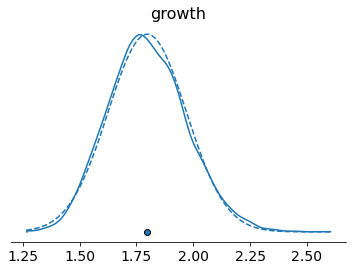

In [ ]:
az.plot_density({'growth': growthsamples}, hdi_prob=1)
x = jnp.sort(growthsamples)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.4

In [ ]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(key, (10000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(key, (10000, 12)), -1)
big, small

(DeviceArray([18.742033 , 11.604453 , 19.078642 , ...,  7.5537906,
              11.295802 , 23.21978  ], dtype=float32),
 DeviceArray([1.0708382, 1.0577757, 1.0716889, ..., 1.0464755, 1.0573572,
              1.076675 ], dtype=float32))

## 4.5

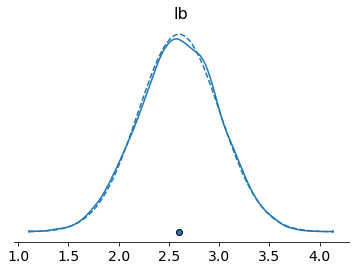

In [ ]:
logbig = jnp.log(big)
az.plot_density({'lb': logbig}, hdi_prob=1)
x = jnp.sort(logbig)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.6

In [ ]:
w, n = 6, 9
pgrid = jnp.linspace(0, 1, 100)
probbin = jnp.exp(dist.Binomial(n, pgrid).log_prob(w))
post = probbin * jnp.exp(dist.Uniform(0, 1).log_prob(pgrid))
post = post / jnp.sum(post)

## 4.7 - 4.11

In [7]:
d = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv', delimiter=';')
print(d.info())
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None


,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [8]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


## 4.12

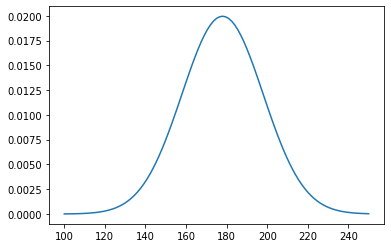

In [ ]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

## 4.13

/usr/local/lib/python3.7/dist-packages/numpyro/distributions/distribution.py:293: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  "Out-of-support values provided to log prob method. "


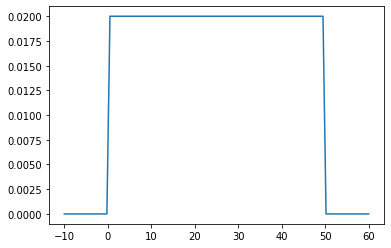

In [ ]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

## 4.14

In [ ]:
samplemu = dist.Normal(178, 20).sample(key, (10000,))
priorh = dist.Normal(samplemu, samplestd)
priorh.sample(key).shape

## 4.15

In [ ]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
samplestd = dist.Uniform(0, 50).sample(random.PRNGKey(1), (10000,))
prior_h = dist.Normal(sample_mu, samplestd).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

## 4.16

Meshgrid returns 2 vars. Now if u iterate thru them, ull get coordinate like results (if not razed, then batch like).

If you use
the obvious approach, like exp(post\$prod ), you’ll get a vector full of zeros, which isn’t very helpful. This
is a result of R’s rounding very small probabilities to zero. Remember, in large samples, all unique samples are
unlikely. This is why you have to work with log-probability. The code in the box dodges this problem by scaling
all of the log-products by the maximum log-product. As a result, the values in post$prob are not all zero, but
they also aren’t exactly probabilities. Instead they are relative posterior probabilities. But that’s good enough for
what we wish to do with these values.

In [10]:
mulist = jnp.linspace(150, 160, 100)
siglist = jnp.linspace(7, 9, 100)
mesh = jnp.meshgrid(mulist, siglist)
post = {'mu': mesh[0].reshape(-1), 'std': mesh[1].reshape(-1)}
post['LL'] = vmap(lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values)))(post['mu'], post['std'])
lmu = dist.Normal(178, 20).log_prob(post['mu'])
lstd = dist.Uniform(0, 50).log_prob(post['std'])
post['prob'] = post['LL'] + lmu + lstd
post['prob'] = jnp.exp(post['prob'] - jnp.max(post['prob']))
post['prob']

DeviceArray([1.9627382e-35, 5.3549957e-34, 1.3573383e-32, ...,
             2.4945987e-29, 2.4997128e-30, 2.3956824e-31], dtype=float32)

## 4.17 - 4.18

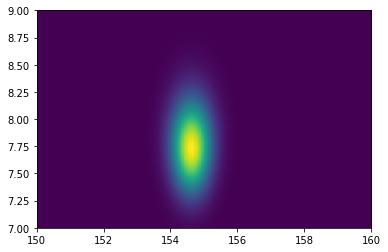

In [ ]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

## 4.19

Dist Categorical is like sampling with replacement ... til n

In [13]:
prob = post['prob'] / jnp.sum(post['prob'])
samplerows = dist.Categorical(probs=prob).sample(key, (10000,))
smu = post['mu'][samplerows]
sstd = post['std'][samplerows]
sstd

DeviceArray([8.191919, 7.828283, 7.181818, ..., 7.787879, 8.191919,
             7.969697], dtype=float32)

## 4.20

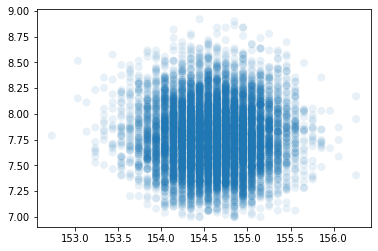

In [15]:
plt.scatter(smu, sstd, s=64, alpha=0.1, edgecolor="none")
plt.show()

## 4.21 - 4.22

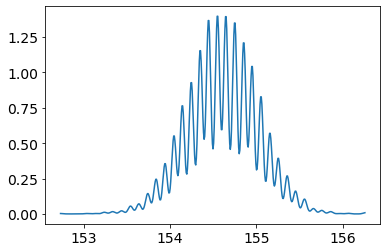

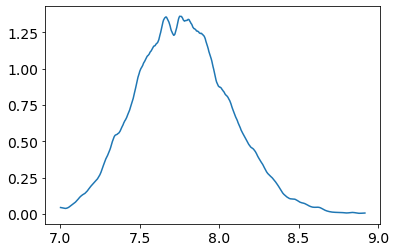

[153.93939 155.15152]
[7.3030305 8.232323 ]


In [19]:
az.plot_kde(smu)
plt.show()
az.plot_kde(sstd)
plt.show()
print(hpdi(smu, 0.89))
print(hpdi(sstd, 0.89))